In [1]:
def load_db(db_path='db.json'):
    import json

    with open('db.json', 'r') as in_file:
        db = json.load(in_file)
        
    return db

In [2]:
def gen_tfidf_dict(db=None, db_path=None):
    import math

    if db is None:
        db = load_db(db_path=db_path)
    
    tfidf = dict()

    for event, transcripts in db['transcript_versioning'].items():
        words = transcripts[-1]['full_text'].lower().split(' ')
        for word in words:
            if word not in tfidf:
                tfidf[word] = dict()
                tfidf[word][event] = dict()
                tfidf[word][event]['count'] = 1

            else:
                if event not in tfidf[word]:
                    tfidf[word][event] = dict()
                    tfidf[word][event]['count'] = 1
                else:
                    tfidf[word][event]['count'] += 1

            tfidf[word][event]['tf'] = tfidf[word][event]['count'] / len(words)
            
    total_events = len(db['events'].keys())
    for word, events in tfidf.items():
        events_containing_word = len(events.keys())
        for event, scores in events.items():
            idf = math.log(total_events / (1 + events_containing_word))
            tfidf[word][event]['idf'] = idf
            tfidf[word][event]['tfidf'] = scores['tf'] * idf
            
    return tfidf

In [3]:
# for word, events in tfidf.items():
#     for event, scores in events.items():
#         print('word:', word, '\nevent:', event, '\nn_docs:', len(events.keys()), '\nscores:', scores)
#         break
#     break

In [4]:
def get_high_value_topics(topics=5, tfidf=None, db=None, db_path=None):
    if tfidf is None:
        if db is None:
            db = load_db(db_path=db_path)
            
        tfidf = gen_tfidf_dict(db=db)
        
    high_values = dict()

    for word, events in tfidf.items():
        for event, scores in events.items():
            try:
                if scores['tfidf'] > min([s['score'] for s in high_values[event]]):
                    new_high = {'word': word, 'score': scores['tfidf']}
                    high_values[event].append(new_high)
                    high_values[event] = sorted(high_values[event], key=lambda i: i['score'], reverse=True)
                    high_values[event] = high_values[event][:topics]
            except KeyError:
                high_values[event] = [{'word': word, 'score': scores['tfidf']}]
                
    return high_values

In [5]:
def print_progress(count, start_time, total):
    import time
    import sys

    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    duration = time.time() - start_time
    completion = '~ 0:0:0 remaining'
    if count > 0:
        avg_time = duration / count
        avg_time = (avg_time * (total - count))
        m, s = divmod(avg_time, 60)
        h, m = divmod(m, 60)
        completion = ('~ %d:%02d:%02d remaining' % (h, m, s))

    sys.stdout.write('[%s] %s%s (%s%s%s) %s\r' %
                     (bar, percents, '%', count, '/', total, completion))
    sys.stdout.flush()

In [6]:
def gen_eot_datas(events=None, decay=False, store_dir='events_over_time/', topics=5, tfidf=None, db=None, db_path=None):
    import json
    import time
    import os
    
    if db is None:
        db = load_db(db_path=db_path)
            
    if tfidf is None:
        tfidf = gen_tfidf_dict(db=db)
        
    if store_dir[-1] != '/':
        store_dir += '/'
        
    if not os.path.exists(store_dir):
        os.makedirs(store_dir)
    
    count = 0
    start = time.time()
    if events is None:
        total = len(db['transcript_versioning'].keys())
    else:
        total = events
        
    high_values = get_high_value_topics(topics=topics, tfidf=tfidf)
    
    for event, transcripts in db['transcript_versioning'].items():
        print_progress(count, start, total)

        words = transcripts[-1]['full_text'].lower().split(' ')
        event_over_time = list()
        for i, word in enumerate(words):
            step = dict()
            for score in high_values[event]:
                if score['word'] == word:
                    if i == 0:
                        step[word] = 1.0
                    else:
                        step[word] = event_over_time[i-1][word] + 1.0
                        
                else:
                    decay_step = tfidf[word][event]['tfidf'] / len(words)
                    
                    if i == 0:
                        if decay:
                            step[score['word']] = 0.0 - decay_step
                        else:
                            step[score['word']] = 0.0
                    else:
                        if decay:
                            step[score['word']] = event_over_time[i-1][score['word']] - decay_step
                        else:
                            step[score['word']] = event_over_time[i-1][score['word']]
                        
            event_over_time.append(step)

        store_path = store_dir
        if decay:
            store_path += 'decay_'
        store_path += event + '.json'
            
        with open(store_path, 'w') as out_file:
            json.dump(event_over_time, out_file)

        count += 1
        
        if events is not None:
            if count >= events:
                break

    print_progress(count, start, total)

In [7]:
def load_eot_data(datapath):
    import json

    with open(datapath, 'r', encoding='utf8', errors='ignore') as in_file:
        eot = json.load(in_file)
    
    return eot

In [8]:
def prep_eot_data(eot):
    last = eot[-1]
    ending_values = sorted(last, key=lambda i: last[i], reverse=True)
    
    y_vals = dict()

    for word in ending_values:
        y_vals[word] = list()
        for step in eot:
            y_vals[word].append(step[word])
    
    return y_vals

In [9]:
def plot_eot(datapath, diff=False, fig_size=(20,10), save=False, show=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    if show:
        %matplotlib inline
    
    fig, axes = plt.subplots(1, 1, figsize=fig_size)

    legend_list = list()

    eot = load_eot_data(datapath=datapath)
    x_vals = np.arange(len(eot))
    y_vals = prep_eot_data(eot)
    for word, vals in y_vals.items():
        if diff:
            y = np.diff(vals)
            x = np.arange(len(y))
            z = np.polyfit(x, y, 3)
            f = np.poly1d(z)
            
            plot_x = np.linspace(x[0], x[-1], 300)
            plot_y = f(plot_x)
        else:
            plot_y = vals
            plot_x = x_vals
        
        axes.plot(plot_x, plot_y)
        legend_list.append(word)

    plt.legend(legend_list, loc='upper left', frameon=False)
    plt.xticks([])
    plt.yticks([])
    if show:
        plt.show()

    if save:
        save_path = datapath.split('/')
        event = save_path[-1]
        event = event.split('.json')
        event = event[0]
        save_path = '/'.join(save_path[:-1]) + '/'
        if diff:
            save_path += 'diff_'
        save_path += event + '.png'
        fig.savefig(save_path)

In [10]:
gen_eot_datas(events=5)

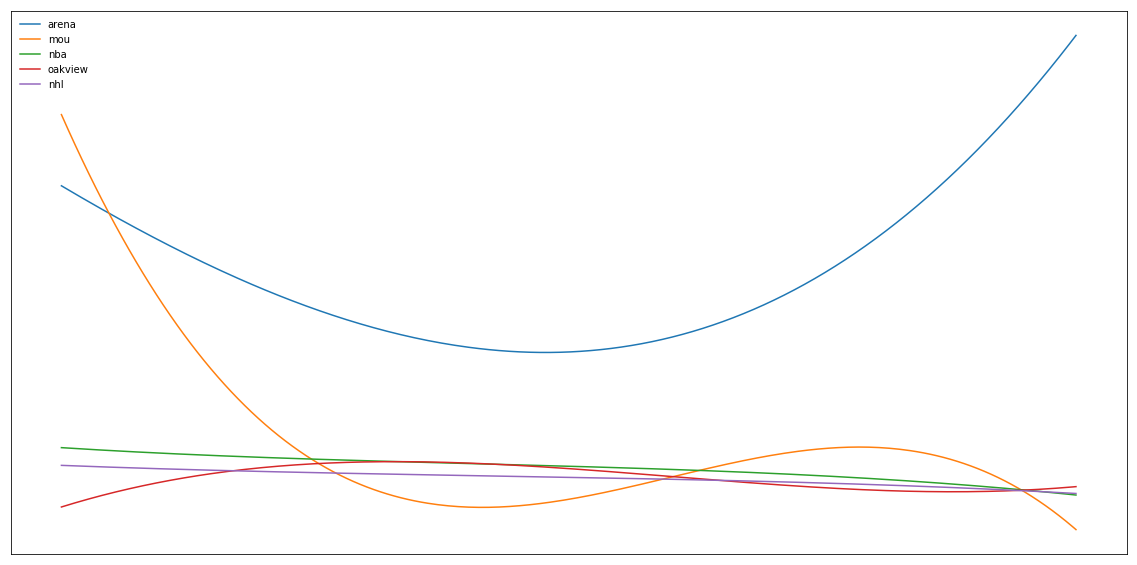

In [11]:
plot_eot('events_over_time/arenas_091817.json', save=True, diff=True)

In [12]:
def gen_eot_images(images=None, diff=False, store_dir='events_over_time/'):
    import time
    import os
    
    if store_dir[-1] != '/':
        store_dir += '/'
    
    all_files = os.listdir(store_dir)
    
    count = 0
    start = time.time()
    if images is None:
        total = len(all_files)
    else:
        total = images
        
    for filepath in all_files:
        print_progress(count, start, total)
        
        datapath = store_dir + filepath
        try:
            plot_eot(datapath=datapath, diff=diff, save=True, show=False)
        except:
            pass
        
        count += 1
        
        if images is not None:
            if count >= images:
                break
                
    print_progress(count, start, total)

In [ ]:
gen_eot_datas()
gen_eot_images(diff=True)